In [45]:
import numpy as np
import pandas as pd
pd.set_option("precision", 3)
import matplotlib.pyplot as plt
from funcs.fitting import loss_single_seg_fixed_T
from datetime import datetime
from funcs.models import model_ND
from scipy.optimize import minimize
from scipy.signal import detrend

The equation governing heat flow in the network is given by:

$$ C_{i} \frac{\mathrm{d} T_{i}}{\mathrm{d} t}=\sum_{j} \frac{1}{R_{j}}\left(T_{j}-T_{i}\right)+\sum Q_{i} $$
$C_i \quad$ capacitance of node $i$ <br>
$T_i \quad$ temperature of node $i$ <br>
$T_j \quad$ temperature of the node interating with node $i$ <br>
$R_j \quad$ resistance between node $i$ and $k$ <br>
$Q_i \quad$ heat supplied to node $i$ <br>

We see that this is identical to the 1D heatflow model we have been using

$$ c_{i} \frac{\mathrm{d} T_{i}}{\mathrm{d} t}=\sum_{j} k_{j}\left(T_{j}-T_{i}\right)+\sum Q_{i} $$

Where the resistance, $R$, is replaced by the inverse of thermal conductivity $1/k$ and capacitance, $C$, is the circuit capacitance.

# RC model
When boiler is off, only k/c (1/RC) ratio matters, thus they may be scaled the same and still have the same fit.
The boiler therefore sets k (1/R) and c (C).

In [46]:
df = pd.read_csv('data/locogen.csv', comment='#')[['time', 'Lobby', 'Meeting', 'Sales', 'Asset Man', 'Break', 'Cons', 'Other (Kitchen)', 'Board', 'Management', 'Energy', 'weather_temperature']]
df = df.interpolate() # remove nans by interpolating
df = df.rename(columns={'weather_temperature':'outside'})
df['gas'] = 0
time_fmt = '%Y-%m-%d %H:%M:%S'
# cols = ['Asset Man', 'Board', 'Break', 'Cons', 'Energy', 'Lobby',
#        'Management', 'Meeting', 'Other (Kitchen)', 'Sales',
#        'weather_tempeature']
indicies = [(3642,3930)]
lower, upper = indicies[0]
rooms = df.columns[1:11]


In [47]:
df['time'] = pd.to_datetime(df['time'], format=time_fmt)
df['timestamp'] = df['time'].values.astype(np.int64)//10**9 # Add a timestamp column, measured in seconds
df.describe()

,Lobby,Meeting,Sales,Asset Man,Break,Cons,Other (Kitchen),Board,Management,Energy,outside,gas,timestamp
count,5693.000,5693.000,5693.000,5693.000,5693.000,5693.000,5693.000,5693.000,5693.000,5693.000,5693.000,5693.0,5.693e+03
mean,12.804,10.776,13.262,14.464,11.973,14.974,12.175,12.777,12.939,12.787,4.950,0.0,1.615e+09
std,5.149,5.031,5.392,5.538,5.267,5.707,5.942,5.545,5.126,5.352,3.878,0.0,2.971e+06
min,5.700,3.700,5.700,5.700,4.400,5.800,3.500,4.000,4.600,5.300,-5.240,0.0,1.609e+09
25%,7.600,5.800,8.100,8.400,6.200,8.700,5.700,6.700,7.200,7.500,2.120,0.0,1.612e+09
50%,12.400,10.200,12.600,15.800,11.900,16.600,11.600,13.700,14.100,12.100,4.740,0.0,1.615e+09
75%,18.000,15.500,18.100,19.300,17.500,20.100,18.100,17.500,17.600,17.500,7.520,0.0,1.617e+09
max,20.700,20.300,22.600,24.300,19.100,23.900,21.700,24.800,22.700,22.700,16.210,0.0,1.620e+09


## Modelling data for room 3 with our single segment model when gas is off

In [48]:
times, Ts_true, Q_in, T_out = df[['timestamp',rooms[0],'gas','outside']].values[lower:upper].T
t0 = times[0]
times = (times-times[0])

In [49]:
# adding solar radiance
freq = 1/86400
y = 5*np.sin(2*np.pi*freq*times) # + const, but const = 0 since march is equinox
y[y<0]=0
Q_in = y # setting heating to solar radiance
df.iloc[lower:upper,-2] = y

In [50]:
# Initial guesses for scipy.optimize.minimize
k0 = 0.25
c0 = 6e4
# k0 = 1.8
# c0 = 5e5
T0 = Ts_true[0]

In [51]:
# optimiser args
bounds = ((None,None),(None,None))
# bounds = ((5e1,1e2),(1.5e7,2.5e7),(15,25))
# bounds = ((0.05,0.5),(1e4,9e4))
tolerance = 1e-30

# results
results_str = '\tInitial\t\t\tEstimated\nk1:\t{:,.5f}\t\t\t{:,.5f}\nc1:\t{:,.2f}\t\t{:,.2f}'

Room Lobby______________________________________
	Initial			Estimated
k1:	0.25000			1.64887
c1:	58,815.10		534,312.10
_____________________________________________
mean RC = 324,046.93


Room Meeting______________________________________
	Initial			Estimated
k1:	0.25000			2.14183
c1:	59,395.13		713,207.65
_____________________________________________
mean RC = 332,989.85


Room Sales______________________________________
	Initial			Estimated
k1:	0.25000			0.88648
c1:	56,981.92		223,557.27
_____________________________________________
mean RC = 252,186.41


Room Asset Man______________________________________
	Initial			Estimated
k1:	0.25000			0.31767
c1:	57,859.13		106,675.93
_____________________________________________
mean RC = 335,809.67


Room Break______________________________________
	Initial			Estimated
k1:	0.25000			0.81594
c1:	59,296.12		284,874.29
_____________________________________________
mean RC = 349,134.42


Room Cons______________________________________
	Initial			

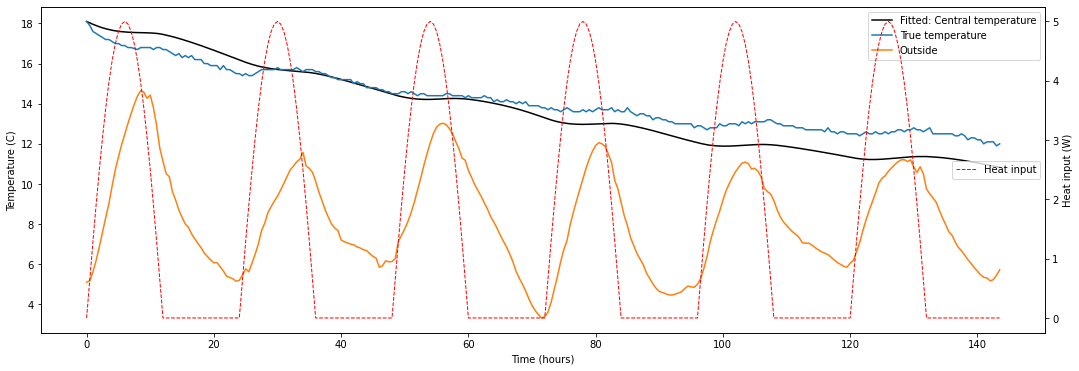

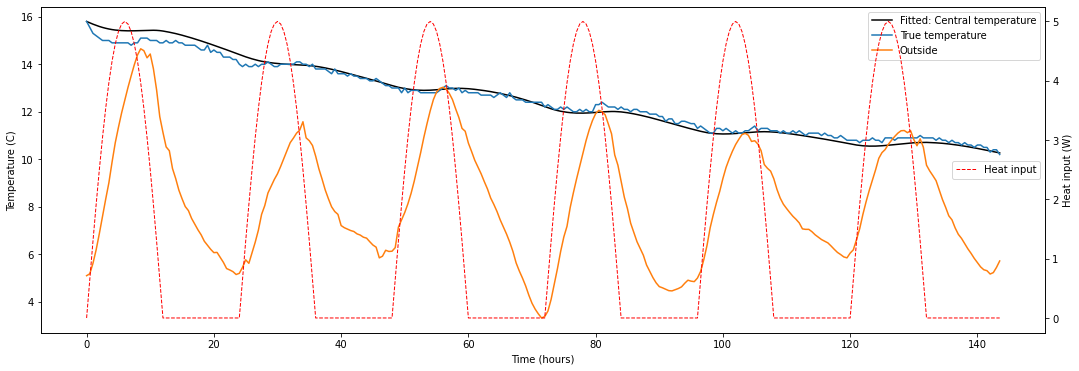

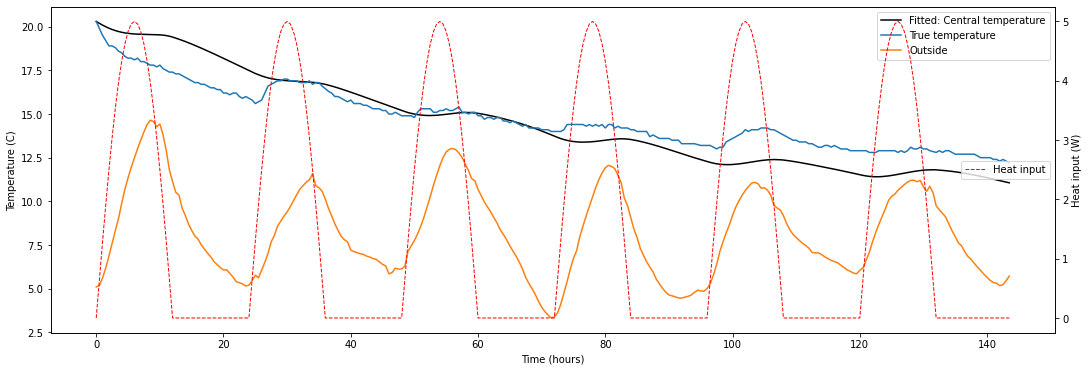

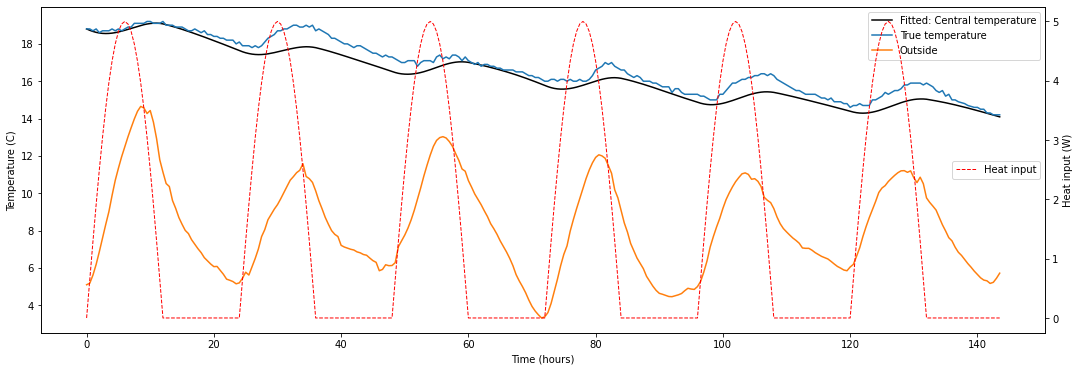

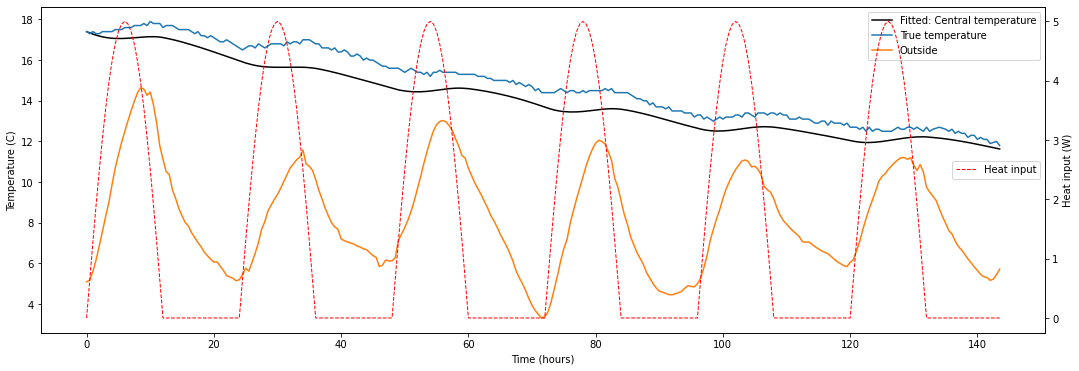

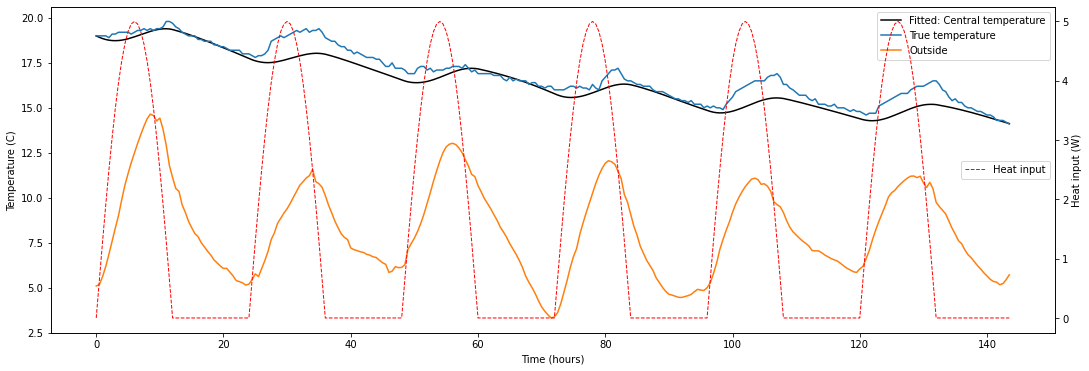

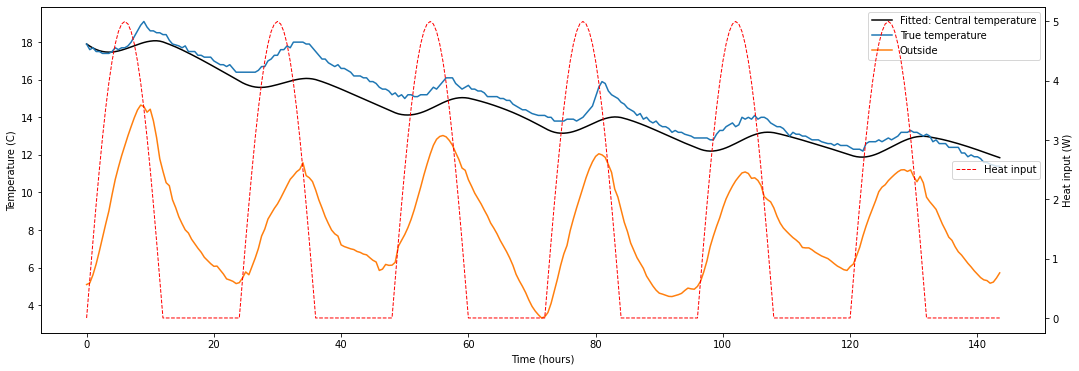

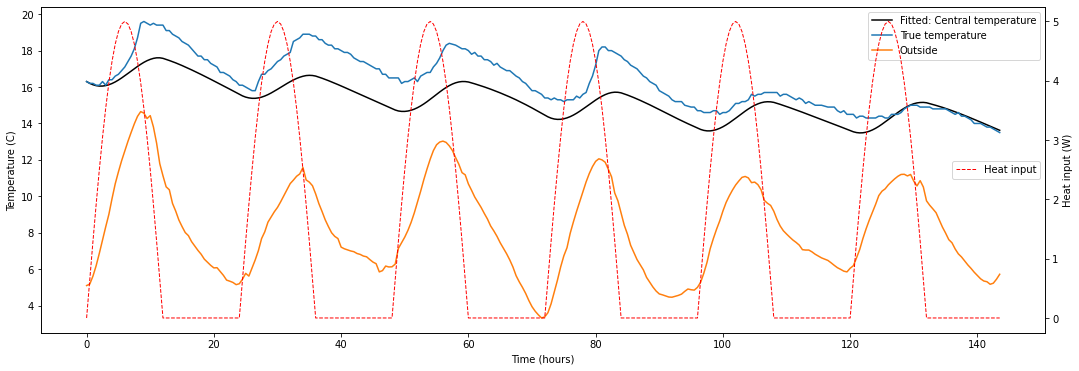

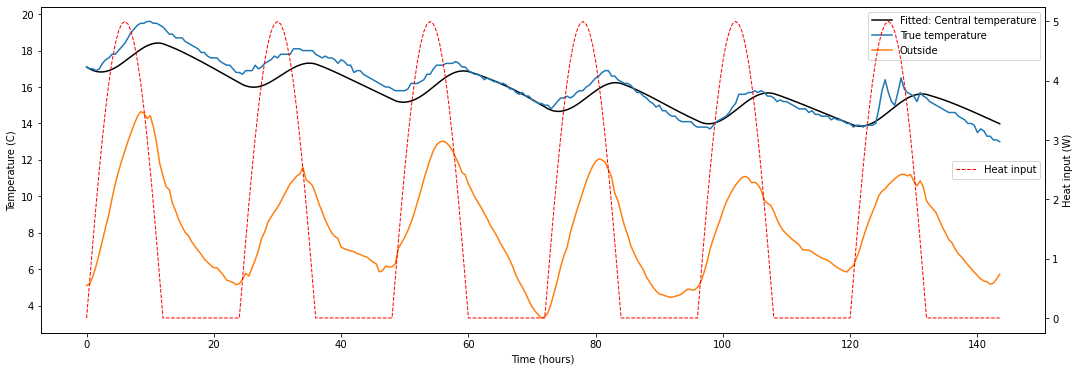

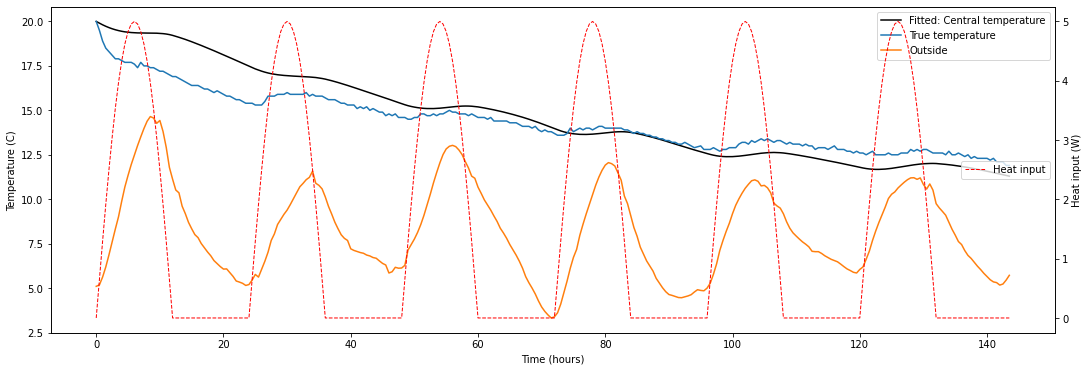

In [52]:
def model_exp(t, tau, T0, t0, T_out):
    return T_out + (T0 - T_out) * np.exp(-(t-t0)/tau)

def model_lin(t, m, T0, t0, T_out):
    return m*(t-t0) + T0

from scipy.optimize import curve_fit


# indicies where gas = 0
mean_RCs = []
mean_fit_exp = []
mean_fit_lin = []
for room in rooms:
    print('Room {}'.format(room)+'_'*38)
    results = []
    fit_exp = []
    fit_lin = []
    for lower, upper in indicies:
        times, Ts_true, Q_in, T_out = df[['timestamp',room,'gas','outside']].values[lower:upper].T
        times = (times-times[0])
        
        # Use variance of detrended curve to estimate initial heat capacity guess
        var = np.var(detrend(Ts_true))
        initial_params = [0.25, 6e4 - var*1e4]
        
        sub_result = []
        for a,b in [(j*288//4,(j+1)*288//4) for j in range(4)]:
            T_i = Ts_true[a]
            sub_result.append(minimize(loss_single_seg_fixed_T, x0=initial_params, tol=tolerance, args=('mse', times[a:b], T_i, Ts_true[a:b], T_out[a:b], Q_in[a:b]), bounds=bounds)['x'])
        result = np.array(sub_result).mean(axis=0)
        k_est, c_est = result
        results.append(result)
        print(results_str.format(*np.ravel([initial_params,result],'F')))
        print('_'*45)

        # Initialise class with system parameters
        sys_fit = model_ND('Fitted', k_est, c_est, Ts_true[0], T_out, Q_in)
        # Run simulation.
        Ts = sys_fit.run(times=times).flatten()
        
        # Model fitting (exp and lin)
        args = (T0, times[0], np.mean(T_out))
        popt_exp, pcov_exp = curve_fit(lambda t, tau: model_exp(t, tau, *args), times, Ts, p0=1e4)
        popt_lin, pcov_lin = curve_fit(lambda t, m:   model_lin(t, m,   *args), times, Ts, p0=-1e-4)

        fit_exp.append(popt_exp)
        fit_lin.append(popt_lin)
        
        # Plotting 
#         if room == rooms[0]:
        if True:
            fig, ax = sys_fit.plot(show_heating=True)
            ax.plot(times/3600, Ts_true, label='True temperature')
#             ax.plot(times/3600, model_exp(times, popt_exp[0], *args), label='Exponential fit')
#             ax.plot(times/3600, model_lin(times, popt_lin[0], *args), label='Linear fit')        
#             sys_guess.plot(figax=figax, ls='-.');
            ax.plot(times/3600, T_out, label='Outside')
            ax.legend();
        
    results = np.array(results)
    # calculating RC from 5 separate intervals where the gas is off
    mean_RC = (results[:,1] / results[:,0]).mean()
    
    mean_RCs.append(mean_RC)
    mean_fit_exp.append(np.array(fit_exp).mean())
    mean_fit_lin.append(np.array(fit_lin).mean())
    print('mean RC = {:,.2f}'.format(mean_RC)) 
    print('='*45+'\n\n')
    

In [53]:
sim_hl = pd.Series(data={room:mean for room, mean in zip(rooms,mean_RCs)}) * np.log(2) / 3600

The half life, $t_{1/2}$, is given by:
$$ t_{1/2} = \ln(2) RC $$

For our linear fit, we estimate a half life using 20Cs starting temp

In [64]:
15/np.array(mean_RCs)*3600

array([0.16664253, 0.16216711, 0.21412732, 0.16080538, 0.15466822,
       0.17774883, 0.26685822, 0.26328346, 0.26589455, 0.1953455 ])

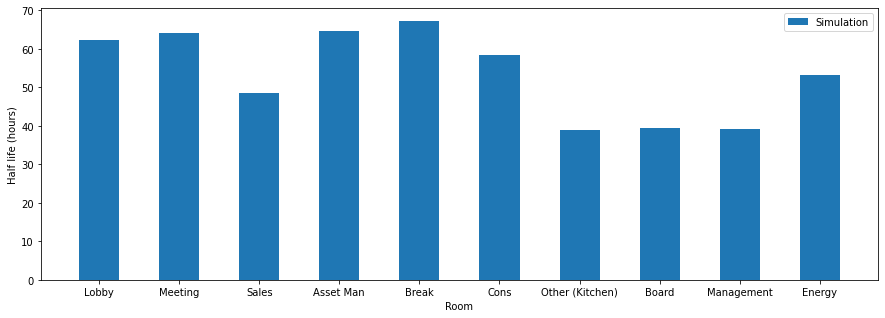

In [59]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
labels = ['Simulation', 'Exponential fit', 'Linear fit']
ind = np.arange(len(sim_hl))
width = 0.5

ax.bar(x = ind, height=series.values, width=width, label=labels[i])

ax.set(xlabel='Room', ylabel='Half life (hours)', xticks=ind, xticklabels=series.index);
ax.legend()

We see that the top and bottom floors have the shortest half life. This is what we would expect if the outside of the building is cold and the building is losing heat to the ground below and air above. The middle floors (level 2 and 3) are best shielded from the surroundings and therefore have the longest half life, ie retain heat for longer.